In [1]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# Faster RCNN ResNet50 without custom classes

In [8]:
import torchvision
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)
model.eval()
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [55]:
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms

def get_prediction(img_path, threshold):
    img = Image.open(img_path) # Load the image
    transform = transforms.Compose([transforms.ToTensor()])
    img = transform(img) # Apply the transform to the image
    pred = model([img]) # Pass the image to the model
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes 
    pred_score = list(pred[0]['scores'].detach().numpy())
    try:
        pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
        pred_boxes = pred_boxes[:pred_t+1]
        pred_class = pred_class[:pred_t+1]
        return pred_boxes, pred_class
    except IndexError as ie:
        print(f'Sorry, no objects were detected that suit the threshold {threshold}')
        return [], []

def object_detection(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
    boxes, pred_cls = get_prediction(img_path, threshold)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
    COLORS = np.random.randint(0, 256, size=(len(np.unique(pred_cls)), 3),
                               dtype="uint8")
    pred_dict = dict(zip(np.unique(pred_cls), COLORS))
    for i in range(len(boxes)):
        color = tuple(int(c) for c in pred_dict[pred_cls[i]])
        cv2.rectangle(img, boxes[i][0], boxes[i][1], color, thickness=rect_th) # Draw Rectangle with the coordinates
        # cv2.putText(img,pred_cls[i], (boxes[i][0][0], boxes[i][0][1]),  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
    plt.figure(figsize=(10,20)) # display the output image
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    markers = [plt.Line2D([0,0],[0,0],color=color/255, marker='o', linestyle='') for color in pred_dict.values()]
    plt.legend(markers, pred_dict.keys(), numpoints=1)
    plt.show()

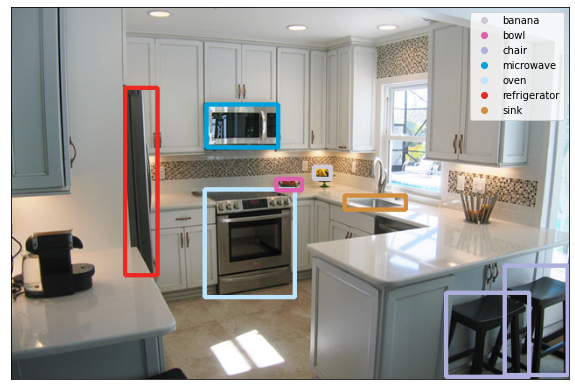

In [57]:
object_detection('/Users/natalie/Downloads/iu.jpeg', threshold=0.7)
